In [74]:
import pandas as pd
import math
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

I'm using yfinance library to download my ticker stock data into a dataframe and setting auto-adjust to True so that all the returned prices are adjusted for potential corporate actions, such as splits.

In [111]:
df = yf.download('AAPL', start='2018-01-01',auto_adjust = True)

[*********************100%***********************]  1 of 1 completed


Plot of the ticker's closing price 

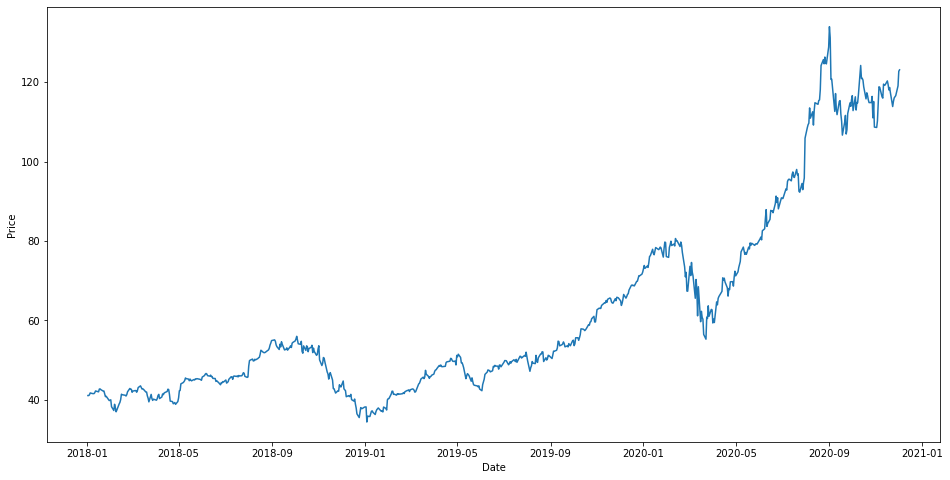

In [112]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel("Date")
plt.ylabel("Price");

For the model, all we need is the ticker's closing price so I first filter the dataframe to only use the 'Close' column. I then create the dataset by converting it to a numpy array.
I then split the dataset by 80% training and 20% for testing.

In [113]:
#create a dataframe with only 'Close' column
data = df.filter(['Close'])

#convert to a numpy array
dataset = data.values

#Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

Next is to preprocess the data. I'm using MinMaxScaler to scale the data for values between 0 and 1.

To compute a prediction, I am using the past 60 days of data to predict the 61st. 
To do so, I create a training data set that contains the past 60 day closing price values.
So the first column in the ‘x_train’ data set will contain values from the data set from index 0 to index 59  and the second column will contain values from the data set from index 1 to index 60 and so on and so forth.
The ‘y_train’ data set will contain the 61st value located at index 60 for it’s first column and the 62nd value located at index 61 of the data set for it’s second value and so on and so forth.

In [114]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [115]:
#Convert x_train and y_train to numpy arrays to be used in training the LSTM model.
x_train, y_train = np.array(x_train), np.array(y_train)

Now I have to reshape the data into the shape accepted by an LSTM.
That is a 3 dimensional input of the form: number of samples, number of time steps and number of features.
The number of samples is the number of rows in our training data, the number of time steps is the number of columns and number of features is just one, the closing price.

In [116]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(529, 60, 1)

Next I build the model, compile it using mean squared error loss and fit it to our training data.
Build the LSTM model to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.

In [199]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
529/529 - 16s - loss: 0.0021
Epoch 2/5
529/529 - 14s - loss: 8.3802e-04
Epoch 3/5
529/529 - 14s - loss: 5.4082e-04
Epoch 4/5
529/529 - 14s - loss: 5.1214e-04
Epoch 5/5
529/529 - 14s - loss: 4.4288e-04


In [201]:
# Create the Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [202]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
#Undo scaling
predictions = scaler.inverse_transform(predictions)

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

6.006981139899916

<ipython-input-140-30b5d680d210>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  valid['Predictions'] = predictions


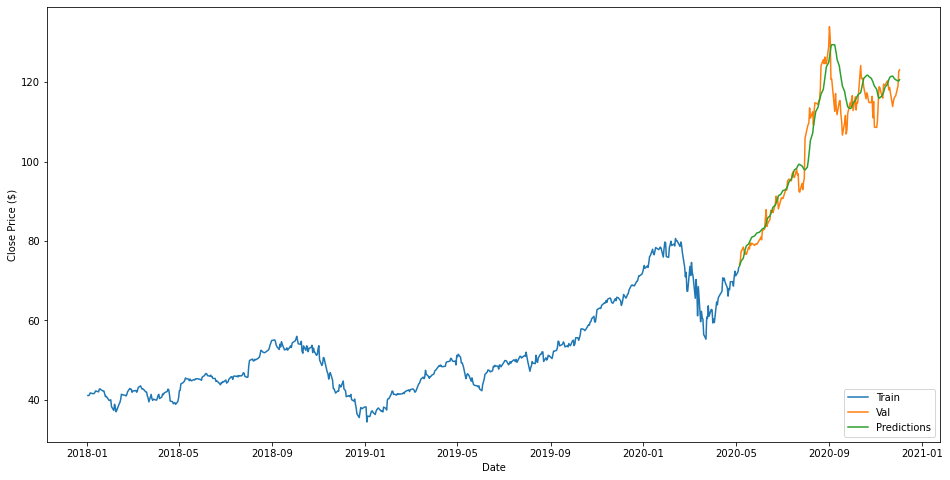

In [140]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [89]:
#show actual and predicted price
valid

,Close,Predictions
Date,,
2020-05-06,156.516006,170.070847
2020-05-07,156.007996,170.598877
2020-05-08,163.884003,171.267624
2020-05-11,162.257996,172.857269
2020-05-12,161.882004,174.616730
2020-05-13,158.192001,176.263077
2020-05-14,160.666000,177.259918
2020-05-15,159.834000,178.079895
2020-05-18,162.725998,178.617035
